Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight

Constants

In [2]:
BATCH_SIZE = 48
IMAGE_SIZE = 224
EPOCHS = 5
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')


Using device: cuda:0


Data Augmentation and Preprocessing

In [3]:
train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomAffine(0, translate=(0.05, 0.05)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),  # <<< TENSÖR'E ÇEVİRME BURADA OLMALI!
    transforms.RandomErasing(p=0.2),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])



test_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

Loading Datasets

In [4]:
train_dataset = datasets.ImageFolder('./dataset/chest_xray/train', transform = train_transforms)
test_dataset = datasets.ImageFolder('./dataset/chest_xray/test', transform = test_transforms)

Calculating Class Weights

In [5]:
y_train = np.array(train_dataset.targets)
class_weights = compute_class_weight('balanced', classes = np.unique(y_train), y = y_train)
class_weights = torch.FloatTensor(class_weights).to(DEVICE)
print(f'Class weights: {class_weights}')

Class weights: tensor([1.9448, 0.6730], device='cuda:0')


Data Loaders

In [6]:
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 4)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = 4)

Class Distribution

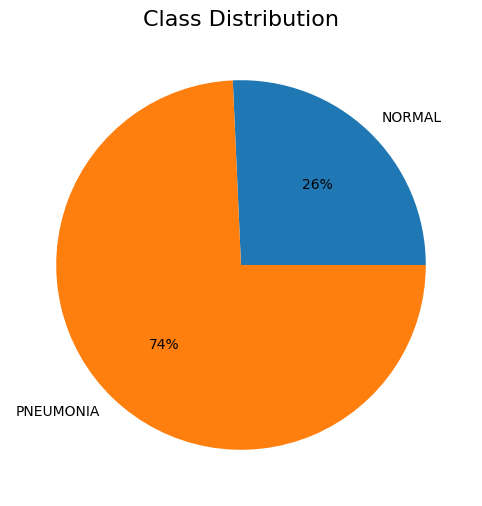

In [7]:
class_names = train_dataset.classes
freq = np.unique(y_train, return_counts = True)
plt.figure(figsize = (8, 6))
plt.title('Class Distribution', fontsize = 16)
plt.pie(freq[1], labels = class_names, autopct = '%1.0f%%')
plt.show()

In [8]:
print('Train Dataset:')
print('Number of images:', len(train_dataset))
print('Number of normal images:', np.sum(y_train == 0))
print('Number of pneumonia images:', np.sum(y_train == 1))

Train Dataset:
Number of images: 5216
Number of normal images: 1341
Number of pneumonia images: 3875


In [9]:
test_targets = np.array(test_dataset.targets)
print('Test Dataset:')
print('Number of images:', len(test_dataset))
print('Number of normal images:', np.sum(test_targets == 0))
print('Number of pneumonia images:', np.sum(test_targets == 1))


Test Dataset:
Number of images: 622
Number of normal images: 232
Number of pneumonia images: 390


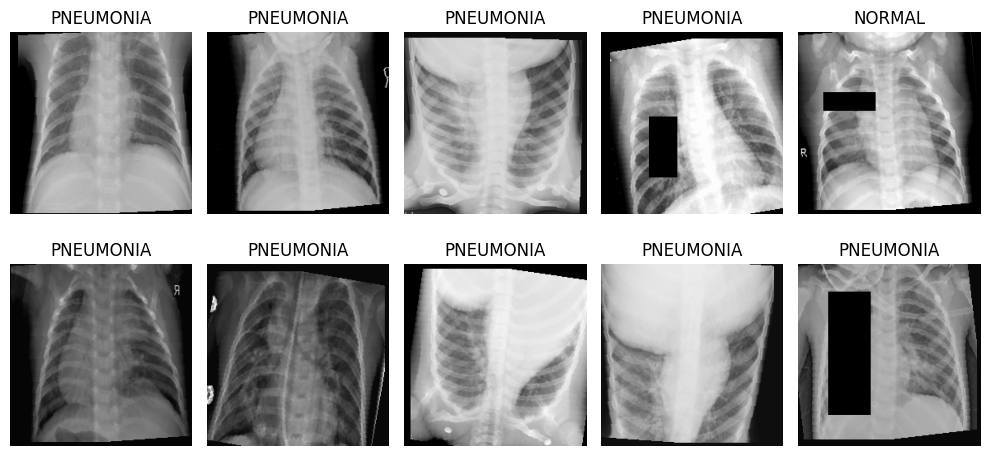

In [10]:
def show_samples(dataloader, num_samples = 10):
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    
    plt.figure(figsize = (10, 5))
    for i in range(num_samples):
        plt.subplot(2, 5, i + 1)
        img = images[i].numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        plt.imshow(img)
        plt.axis('off')
        plt.title(class_names[labels[i]])
    
    plt.tight_layout()
    plt.show()

show_samples(train_loader)

Model Class

In [11]:
class PneumoniaModel(nn.Module):
    def __init__(self, num_classes=2):
        super(PneumoniaModel, self).__init__()
        # Load pre-trained MobileNetV2
        self.mobilenet = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
        
        # Freeze base layers
        for param in self.mobilenet.parameters():
            param.requires_grad = False
            
        # Modify the classifier
        num_features = self.mobilenet.classifier[1].in_features
        self.mobilenet.classifier = nn.Identity()
        
        # Custom classifier
        self.classifier = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x):
        x = self.mobilenet(x)
        x = self.classifier(x)
        return x

In [12]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_acc):
        if self.best_score is None:
            self.best_score = val_acc
        elif val_acc < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_acc
            self.counter = 0


Training Function

In [13]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=EPOCHS, early_stopper=None):
    best_acc = 0.0
    best_model_wts = model.state_dict()
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc.item())
        
        # Validation
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = running_corrects.double() / len(val_loader.dataset)
        val_losses.append(epoch_loss)
        val_accs.append(epoch_acc.item())
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f}')
        print(f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}')
        
        # Save best model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = model.state_dict().copy()
        
        if scheduler:
            scheduler.step(epoch_acc)
        
        if early_stopper:
            early_stopper(val_accs[-1])
            if early_stopper.early_stop:
                print("Early stopping triggered!")
                break

    model.load_state_dict(best_model_wts)
    
    history = {
        'train_loss': train_losses,
        'train_acc': train_accs,
        'val_loss': val_losses,
        'val_acc': val_accs
    }
    
    return model, history


In [14]:
model = PneumoniaModel().to(DEVICE)
criterion = nn.CrossEntropyLoss(weight = class_weights)
optimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay = 0.001)
scheduler= optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor = 0.5, patience = 2)
early_stopper = EarlyStopping(patience=3, min_delta=0.001)
model, initial_history = train_model(model, 
                                     train_loader, 
                                     test_loader, 
                                     criterion, 
                                     optimizer, 
                                     scheduler,
                                     num_epochs=EPOCHS,
                                     early_stopper=early_stopper)

Epoch 1/5:
Train Loss: 0.3984, Train Acc: 0.8014
Val Loss: 0.4935, Val Acc: 0.8103
Epoch 2/5:
Train Loss: 0.2993, Train Acc: 0.8767
Val Loss: 0.3066, Val Acc: 0.8746
Epoch 3/5:
Train Loss: 0.2594, Train Acc: 0.8909
Val Loss: 0.5282, Val Acc: 0.8199
Epoch 4/5:
Train Loss: 0.2383, Train Acc: 0.9011
Val Loss: 0.3335, Val Acc: 0.8810
Epoch 5/5:
Train Loss: 0.2381, Train Acc: 0.9038
Val Loss: 0.3624, Val Acc: 0.8794


Fine Tuning

In [15]:
for i, (name, param) in enumerate(model.mobilenet.named_parameters()):
    if i > len(list(model.mobilenet.named_parameters())) // 2:  
        param.requires_grad = True

# Use lower learning rate for fine-tuning
optimizer_ft = optim.Adam(model.parameters(), lr=1e-5)
model, ft_history = train_model(model, train_loader, test_loader, criterion, optimizer_ft)

Epoch 1/5:
Train Loss: 0.2015, Train Acc: 0.9208
Val Loss: 0.3284, Val Acc: 0.8923
Epoch 2/5:
Train Loss: 0.1808, Train Acc: 0.9310
Val Loss: 0.3273, Val Acc: 0.9019
Epoch 3/5:
Train Loss: 0.1507, Train Acc: 0.9410
Val Loss: 0.3078, Val Acc: 0.9035
Epoch 4/5:
Train Loss: 0.1276, Train Acc: 0.9486
Val Loss: 0.3157, Val Acc: 0.9003
Epoch 5/5:
Train Loss: 0.1331, Train Acc: 0.9509
Val Loss: 0.3783, Val Acc: 0.8891


In [16]:
def evaluate_model(model, dataloader):
    model.eval()
    all_predictions = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_predictions.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return np.array(all_labels), np.array(all_predictions), np.array(all_probs)

In [17]:
y_true, y_pred, y_prob = evaluate_model(model, test_loader)


Confusion Matrix

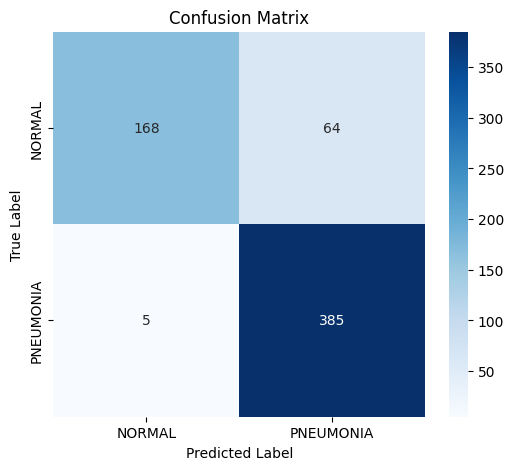

In [18]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [19]:
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.97      0.72      0.83       232
   PNEUMONIA       0.86      0.99      0.92       390

    accuracy                           0.89       622
   macro avg       0.91      0.86      0.87       622
weighted avg       0.90      0.89      0.88       622



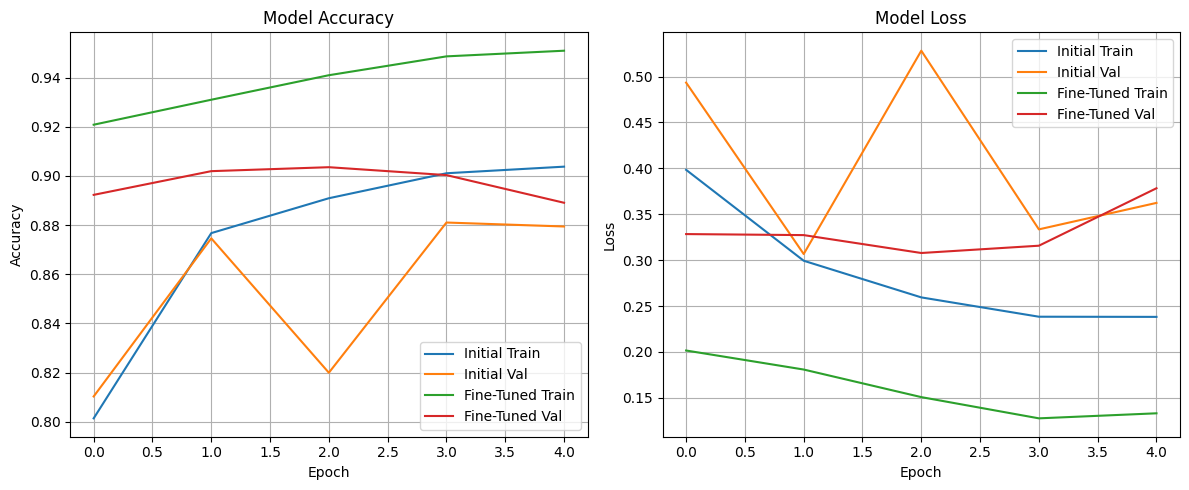

In [20]:
def plot_training_history(histories, labels):
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    for i, (hist, label) in enumerate(zip(histories, labels)):
        plt.plot(hist['train_acc'], label=f'{label} Train')
        plt.plot(hist['val_acc'], label=f'{label} Val')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)
    
    # Plot loss
    plt.subplot(1, 2, 2)
    for i, (hist, label) in enumerate(zip(histories, labels)):
        plt.plot(hist['train_loss'], label=f'{label} Train')
        plt.plot(hist['val_loss'], label=f'{label} Val')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_history(
    [initial_history, ft_history],
    labels=['Initial', 'Fine-Tuned']
)

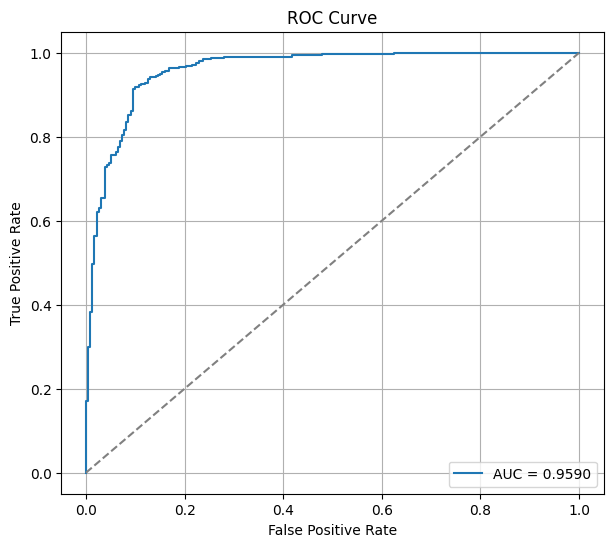

In [21]:
fpr, tpr, thresholds = roc_curve(y_true, y_prob[:, 1])  # 1 = PNEUMONIA
auc_score = roc_auc_score(y_true, y_prob[:, 1])

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

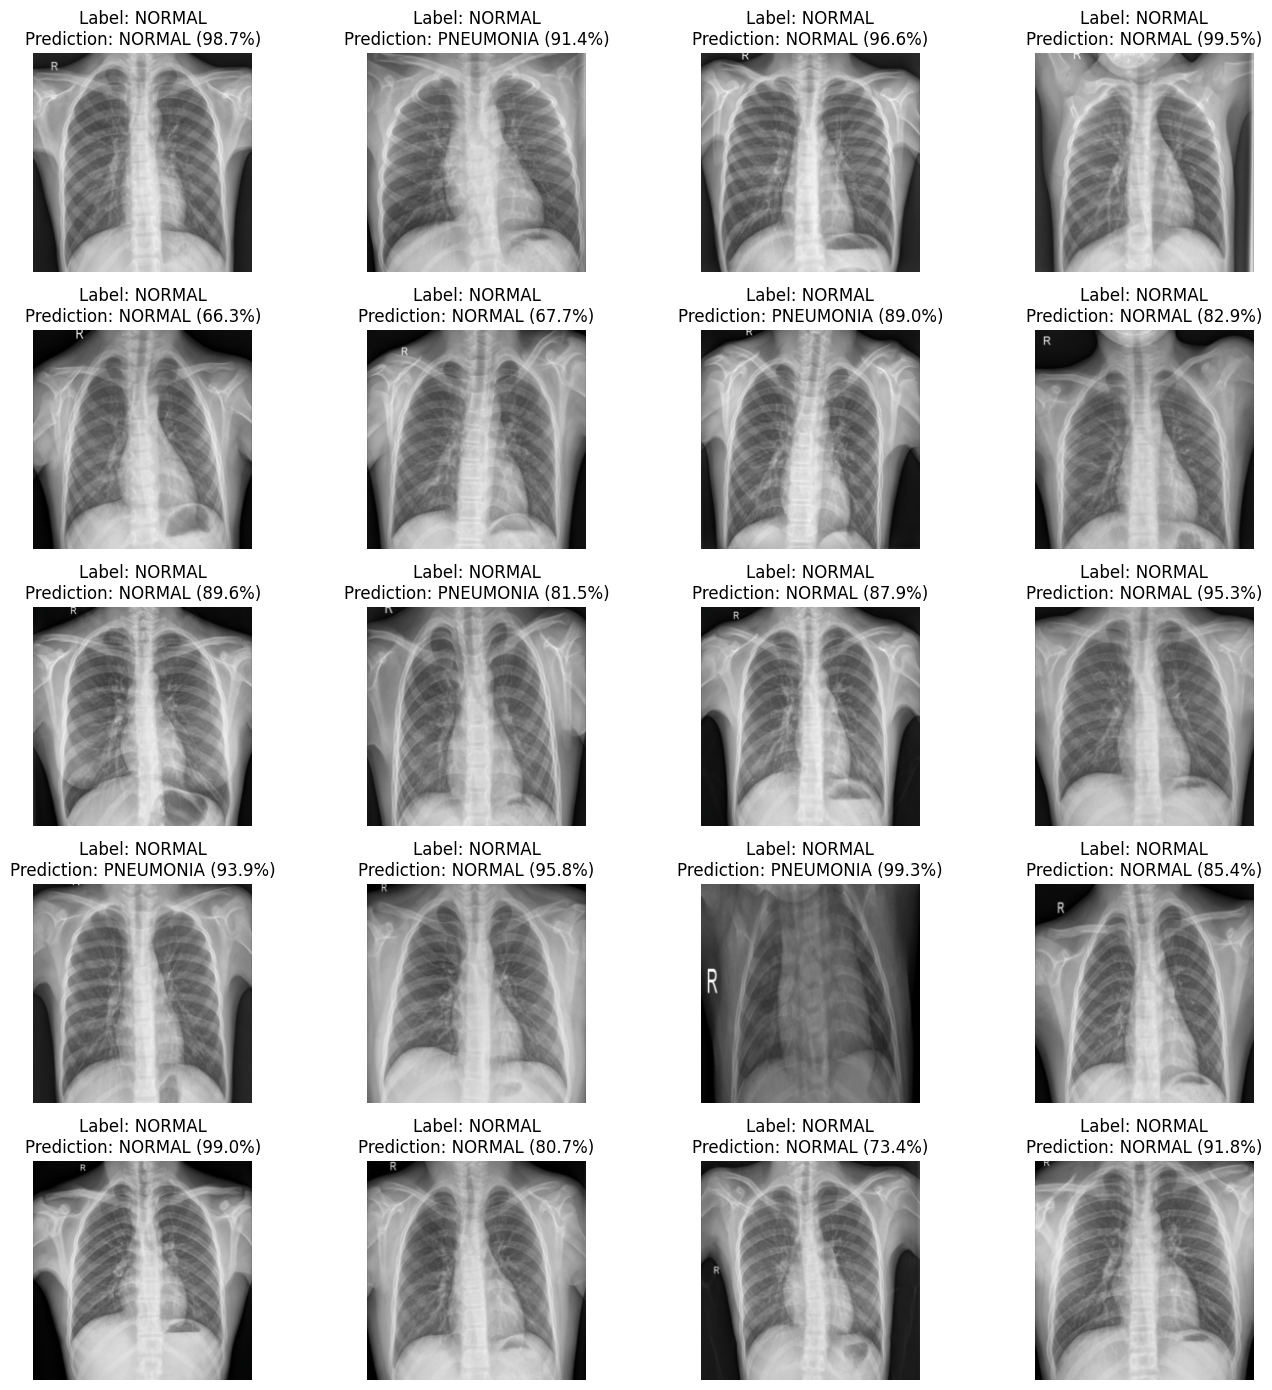

In [22]:
def show_predictions(model, dataloader, num_samples=20):
    model.eval()
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    images, labels = images.to(DEVICE), labels.to(DEVICE)
    
    with torch.no_grad():
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
    
    images = images.cpu().numpy()
    labels = labels.cpu().numpy()
    preds = preds.cpu().numpy()
    probs = probs.cpu().numpy()
    
    plt.figure(figsize=[14, 14])
    for i in range(min(num_samples, len(images))):
        plt.subplot(5, 4, i+1)
        
        # Un-normalize for display
        img = images[i].transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        plt.imshow(img)
        plt.axis('off')
        true_label = class_names[labels[i]]
        predicted_label = class_names[preds[i]]
        confidence = 100 * np.max(probs[i])
        plt.title(f"Label: {true_label}\nPrediction: {predicted_label} ({confidence:.1f}%)")
    plt.tight_layout()
    plt.show()

show_predictions(model, test_loader)

In [23]:
torch.save(model.state_dict(), 'pneumonia_model_pytorch.pth')

# To load the model later
def load_model(model_path):
    model = PneumoniaModel()
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

GRAD-CAM

In [28]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.target_layer = target_layer
        
        self.gradients = None
        self.activations = None
        
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, target_class=None):
        output = self.model(input_tensor)

        if target_class is None:
            target_class = output.argmax(dim=1)

        loss = output[:, target_class]
        self.model.zero_grad()
        loss.backward(retain_graph=True)
        
        # Grad-CAM hesaplama
        gradients = self.gradients
        activations = self.activations
        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
        
        for i in range(activations.shape[1]):
            activations[:, i, :, :] *= pooled_gradients[i]
        
        heatmap = activations.sum(dim=1).squeeze()
        heatmap = F.relu(heatmap)
        heatmap /= torch.max(heatmap)
        heatmap = heatmap.cpu().numpy()

        heatmap = cv2.resize(heatmap, (input_tensor.size(-1), input_tensor.size(-2)))

        return heatmap


In [26]:
def show_gradcam(model, dataloader, class_names, target_layer):
    model.eval()
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    
    idx = np.random.randint(0, len(images))
    image = images[idx].unsqueeze(0)  # Tek görüntü
    label = labels[idx]
    
    gradcam = GradCAM(model, target_layer)
    cam = gradcam.generate_cam(image)
    
    # Görüntüyü geri dönüştür (normalize'ı tersine al)
    img = image.squeeze().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    # Isı haritası üret
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    heatmap = heatmap[..., ::-1]  # BGR to RGB
    cam_img = 0.4 * heatmap + 0.6 * img
    cam_img = np.clip(cam_img, 0, 1)
    
    # Sonuçları çiz
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title(f"Original ({class_names[label]})")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(cam, cmap='jet')
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(cam_img)
    plt.title("Overlay")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


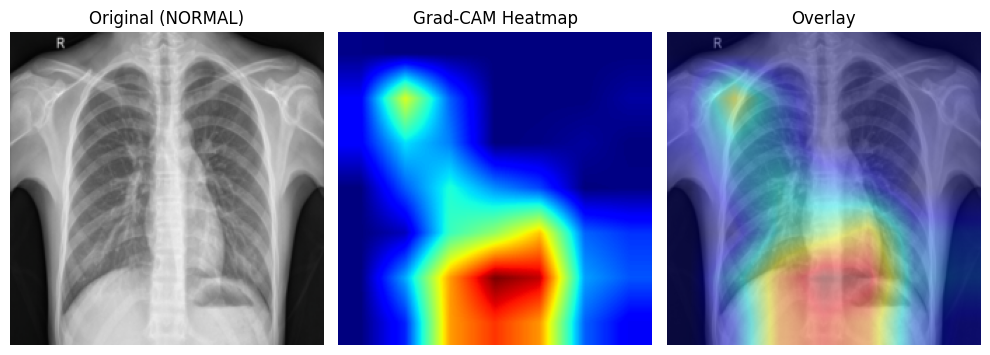

In [ ]:
target_layer = model.mobilenet.features[-1]

show_gradcam(model, test_loader, class_names, target_layer)
